In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping
import pandas as pd

In [2]:
plt.rcParams.update({'font.size': 18})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [3]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'

In [4]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [35]:
regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

In [9]:
# Plot climatology

# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

# Integrate over entire AIS / basin for time series
flux_clm_ts = flux_clm.sum(['y','x']) # Seasonality / Climatology?
flux_anm_ts = flux_anm.sum(['y','x'], skipna=True)

Text(0.5, 1.0, 'Annual Climatology')

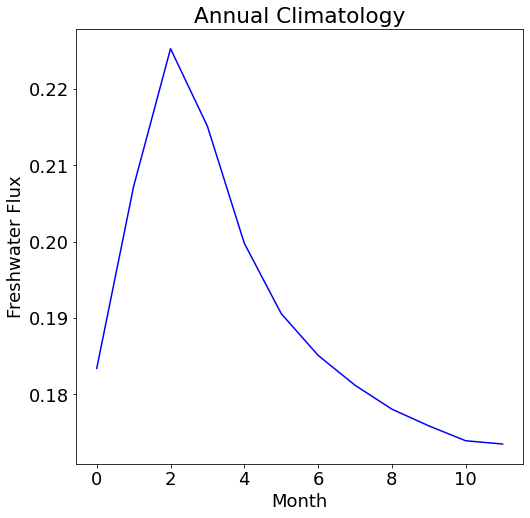

In [29]:
plt.figure(figsize=(8,8))
plt.plot(range(12),flux_clm_ts,color='b') 
plt.ylabel('Freshwater Flux')
plt.xlabel('Month')
plt.title('Annual Climatology')

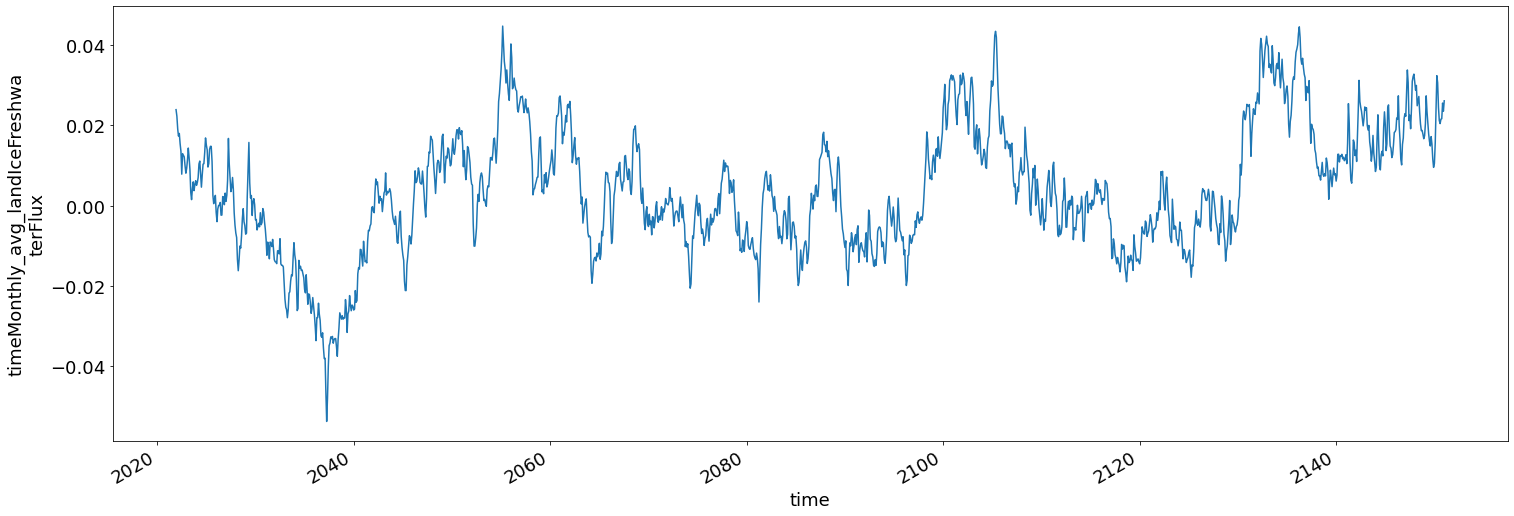

In [39]:
plt.figure(figsize=(25,8))
#plt.plot(flux_anm_ts)
flux_anm_ts[250:].plot()
#plt.ylabel('Freshwater Flux')
#plt.xlabel('Month')
#plt.title('Annual Climatology')

In [41]:
# Plot scatterplot of melt-draft
flux_clean_ts = flux_clean.sum(['y','x'])

Text(0.5, 0, 'Time (months)')

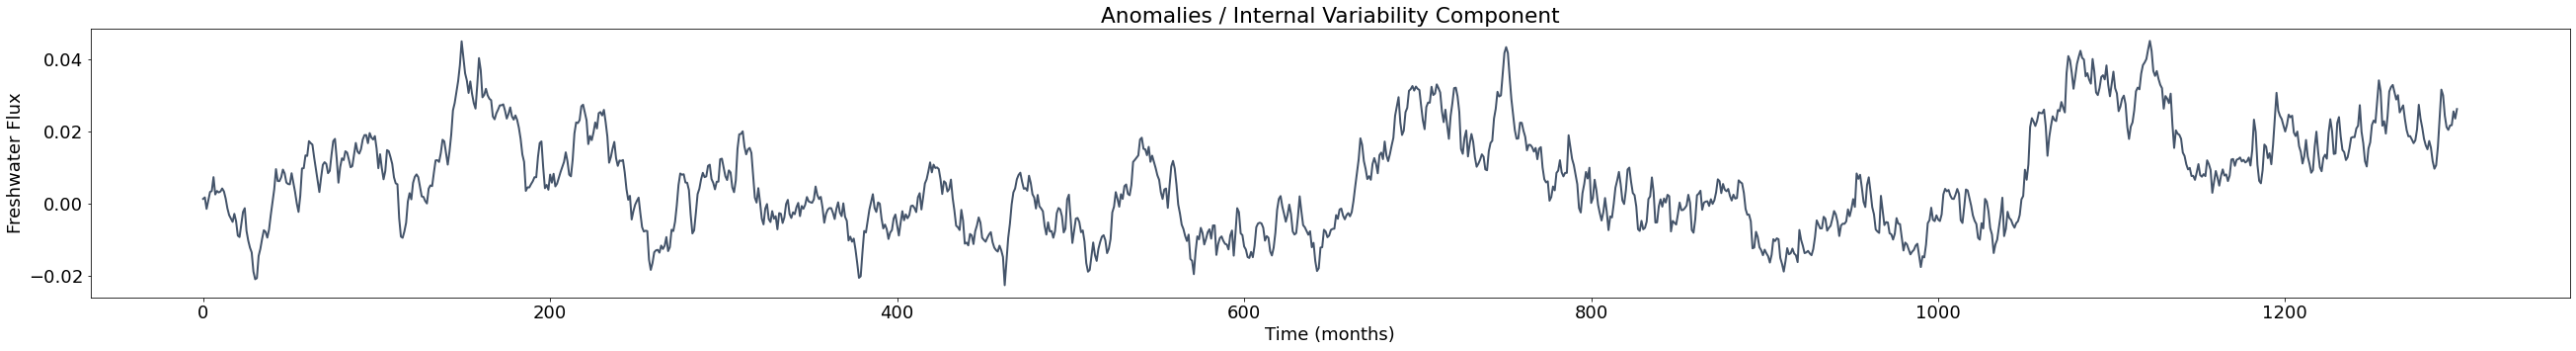

In [57]:
plt.figure(figsize=(45,5))
#plt.plot(flux_anm_ts)
plt.plot(flux_clean_ts[200:], color = '#44546A', linewidth=2)
plt.title('Anomalies / Internal Variability Component')
plt.ylabel('Freshwater Flux')
plt.xlabel('Time (months)')

In [6]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [7]:
%%time
model = EOF(flux_clean)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

CPU times: user 2min 40s, sys: 50.3 s, total: 3min 30s
Wall time: 1min 4s


Text(0.5, 1.0, 'Relative Power of EOFs')

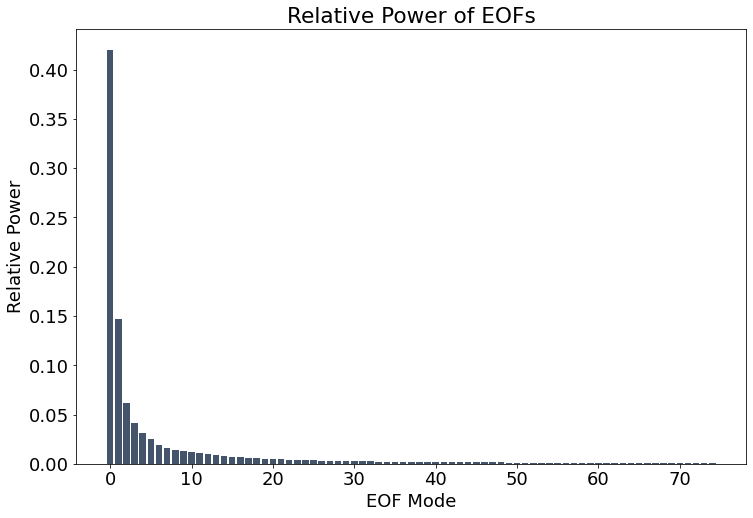

In [8]:
plt.figure(figsize=(12,8))
plt.bar(range(75),varexpl[:75], color='#44546A')
plt.ylabel('Relative Power')
plt.xlabel('EOF Mode')
plt.title('Relative Power of EOFs')

In [66]:
basin = 55
basin_flux = flux_clean.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

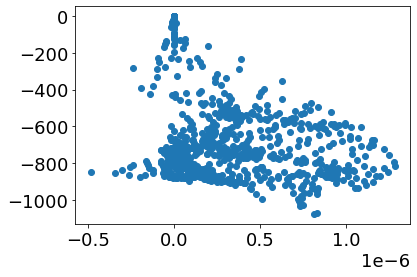

In [67]:
basin_flux_tmean = basin_flux.mean('time')
plt.scatter(basin_flux_tmean,ssh[1])

In [65]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(icems.name)

0           Filchner-Ronne
1                     Ross
2               Antarctica
3                Peninsula
4          West Antarctica
5          East Antarctica
6                   IMBIE1
7                   IMBIE2
8                   IMBIE3
9                   IMBIE4
10                  IMBIE5
11                  IMBIE6
12                  IMBIE7
13                  IMBIE8
14                  IMBIE9
15                 IMBIE10
16                 IMBIE11
17                 IMBIE12
18                 IMBIE13
19                 IMBIE14
20                 IMBIE15
21                 IMBIE16
22                 IMBIE17
23                 IMBIE18
24                 IMBIE19
25                 IMBIE20
26                 IMBIE21
27                 IMBIE22
28                 IMBIE23
29                 IMBIE24
30                 IMBIE25
31                 IMBIE26
32                 IMBIE27
33                   Abbot
34                   Amery
35                    Atka
36                 Aviator
3

In [72]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 2
t_length = pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization i, mode: {}'.format(m))

calculated ifft for realization i, mode: 0
calculated ifft for realization i, mode: 1
calculated ifft for realization i, mode: 2
calculated ifft for realization i, mode: 3
calculated ifft for realization i, mode: 4
calculated ifft for realization i, mode: 5
calculated ifft for realization i, mode: 6
calculated ifft for realization i, mode: 7
calculated ifft for realization i, mode: 8
calculated ifft for realization i, mode: 9
calculated ifft for realization i, mode: 10
calculated ifft for realization i, mode: 11
calculated ifft for realization i, mode: 12
calculated ifft for realization i, mode: 13
calculated ifft for realization i, mode: 14
calculated ifft for realization i, mode: 15
calculated ifft for realization i, mode: 16
calculated ifft for realization i, mode: 17
calculated ifft for realization i, mode: 18
calculated ifft for realization i, mode: 19
calculated ifft for realization i, mode: 20
calculated ifft for realization i, mode: 21
calculated ifft for realization i, mode: 2

calculated ifft for realization i, mode: 480
calculated ifft for realization i, mode: 481
calculated ifft for realization i, mode: 482
calculated ifft for realization i, mode: 483
calculated ifft for realization i, mode: 484
calculated ifft for realization i, mode: 485
calculated ifft for realization i, mode: 486
calculated ifft for realization i, mode: 487
calculated ifft for realization i, mode: 488
calculated ifft for realization i, mode: 489
calculated ifft for realization i, mode: 490
calculated ifft for realization i, mode: 491
calculated ifft for realization i, mode: 492
calculated ifft for realization i, mode: 493
calculated ifft for realization i, mode: 494
calculated ifft for realization i, mode: 495
calculated ifft for realization i, mode: 496
calculated ifft for realization i, mode: 497
calculated ifft for realization i, mode: 498
calculated ifft for realization i, mode: 499
calculated ifft for realization i, mode: 500
calculated ifft for realization i, mode: 501
calculated

calculated ifft for realization i, mode: 963
calculated ifft for realization i, mode: 964
calculated ifft for realization i, mode: 965
calculated ifft for realization i, mode: 966
calculated ifft for realization i, mode: 967
calculated ifft for realization i, mode: 968
calculated ifft for realization i, mode: 969
calculated ifft for realization i, mode: 970
calculated ifft for realization i, mode: 971
calculated ifft for realization i, mode: 972
calculated ifft for realization i, mode: 973
calculated ifft for realization i, mode: 974
calculated ifft for realization i, mode: 975
calculated ifft for realization i, mode: 976
calculated ifft for realization i, mode: 977
calculated ifft for realization i, mode: 978
calculated ifft for realization i, mode: 979
calculated ifft for realization i, mode: 980
calculated ifft for realization i, mode: 981
calculated ifft for realization i, mode: 982
calculated ifft for realization i, mode: 983
calculated ifft for realization i, mode: 984
calculated

calculated ifft for realization i, mode: 1465
calculated ifft for realization i, mode: 1466
calculated ifft for realization i, mode: 1467
calculated ifft for realization i, mode: 1468
calculated ifft for realization i, mode: 1469
calculated ifft for realization i, mode: 1470
calculated ifft for realization i, mode: 1471
calculated ifft for realization i, mode: 1472
calculated ifft for realization i, mode: 1473
calculated ifft for realization i, mode: 1474
calculated ifft for realization i, mode: 1475
calculated ifft for realization i, mode: 1476
calculated ifft for realization i, mode: 1477
calculated ifft for realization i, mode: 1478
calculated ifft for realization i, mode: 1479
calculated ifft for realization i, mode: 1480
calculated ifft for realization i, mode: 1481
calculated ifft for realization i, mode: 1482
calculated ifft for realization i, mode: 1483
calculated ifft for realization i, mode: 1484
calculated ifft for realization i, mode: 1485
calculated ifft for realization i,

calculated ifft for realization i, mode: 458
calculated ifft for realization i, mode: 459
calculated ifft for realization i, mode: 460
calculated ifft for realization i, mode: 461
calculated ifft for realization i, mode: 462
calculated ifft for realization i, mode: 463
calculated ifft for realization i, mode: 464
calculated ifft for realization i, mode: 465
calculated ifft for realization i, mode: 466
calculated ifft for realization i, mode: 467
calculated ifft for realization i, mode: 468
calculated ifft for realization i, mode: 469
calculated ifft for realization i, mode: 470
calculated ifft for realization i, mode: 471
calculated ifft for realization i, mode: 472
calculated ifft for realization i, mode: 473
calculated ifft for realization i, mode: 474
calculated ifft for realization i, mode: 475
calculated ifft for realization i, mode: 476
calculated ifft for realization i, mode: 477
calculated ifft for realization i, mode: 478
calculated ifft for realization i, mode: 479
calculated

calculated ifft for realization i, mode: 950
calculated ifft for realization i, mode: 951
calculated ifft for realization i, mode: 952
calculated ifft for realization i, mode: 953
calculated ifft for realization i, mode: 954
calculated ifft for realization i, mode: 955
calculated ifft for realization i, mode: 956
calculated ifft for realization i, mode: 957
calculated ifft for realization i, mode: 958
calculated ifft for realization i, mode: 959
calculated ifft for realization i, mode: 960
calculated ifft for realization i, mode: 961
calculated ifft for realization i, mode: 962
calculated ifft for realization i, mode: 963
calculated ifft for realization i, mode: 964
calculated ifft for realization i, mode: 965
calculated ifft for realization i, mode: 966
calculated ifft for realization i, mode: 967
calculated ifft for realization i, mode: 968
calculated ifft for realization i, mode: 969
calculated ifft for realization i, mode: 970
calculated ifft for realization i, mode: 971
calculated

calculated ifft for realization i, mode: 1444
calculated ifft for realization i, mode: 1445
calculated ifft for realization i, mode: 1446
calculated ifft for realization i, mode: 1447
calculated ifft for realization i, mode: 1448
calculated ifft for realization i, mode: 1449
calculated ifft for realization i, mode: 1450
calculated ifft for realization i, mode: 1451
calculated ifft for realization i, mode: 1452
calculated ifft for realization i, mode: 1453
calculated ifft for realization i, mode: 1454
calculated ifft for realization i, mode: 1455
calculated ifft for realization i, mode: 1456
calculated ifft for realization i, mode: 1457
calculated ifft for realization i, mode: 1458
calculated ifft for realization i, mode: 1459
calculated ifft for realization i, mode: 1460
calculated ifft for realization i, mode: 1461
calculated ifft for realization i, mode: 1462
calculated ifft for realization i, mode: 1463
calculated ifft for realization i, mode: 1464
calculated ifft for realization i,

In [77]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [78]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [79]:
# Reconstruct flux dataset using phase randomized PCs.
# This section is to be called iteratively for ensemble runs with multiple realizations.
# This method also takes 'modes' as a parameter - used to reconstruct dataset with different number of selected modes
def generate_data(mode,mode_skip):
    
    flux_reconstr = model.reconstruct_randomized_X(new_fl[0],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [117]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
    clipped_data = clipped_data.dropna('time',how='all')
    clipped_data = clipped_data.dropna('y',how='all')
    clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

In [ ]:
flux_clean.rio.clip(icems.loc[[basin],'geometry']

In [80]:
flux_clean_mean = flux_clean.mean('time')

In [81]:
mode_skip = 1
xeofs_modes = list(range(71,nmodes+1))
yxcoords = np.argwhere(np.array(flux_clean_mean))
yxcoordsna = np.nonzero(np.array(flux_clean_mean))

In [87]:
flux_reconstr = model.reconstruct_randomized_X(new_fl[0],slice(61))

In [118]:
rec = clip_data(flux_reconstr,4)
orig = clip_data(flux_clean,4)

In [119]:
orig_ts = time_series(orig)
rec_ts = time_series(rec)

In [120]:
rec_thw = clip_data(flux_reconstr,114)
orig_thw = clip_data(flux_clean,114)

In [121]:
orig_thw_ts = time_series(orig_thw)
rec_thw_ts = time_series(rec_thw)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


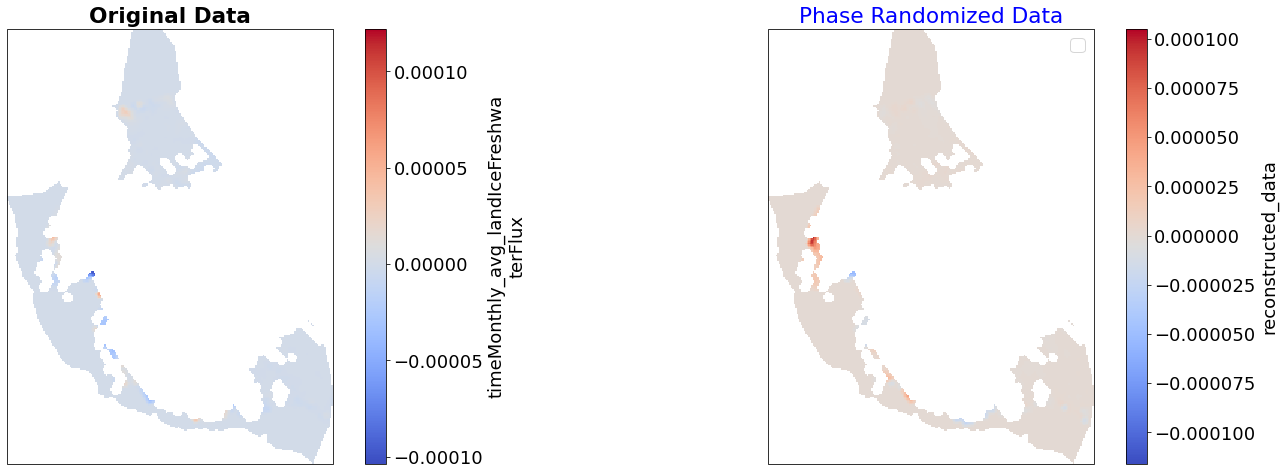

In [130]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, axs = plt.subplots(1,2,figsize=(25,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

#axs[0, 0].set_title('Axis [0, 0]')

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values
plt.subplot(121)
cax1 = orig[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = np.max(orig)/2, vmin = np.min(orig)/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Original Data: " + str(orig_ameryn.coords['time'].values[frame])[:7])
plt.title("Original Data", color= 'black', fontweight='bold')


plt.subplot(122)
cax2 = rec[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = np.max(rec)/2, vmin = np.min(rec)/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("Phase Randomized Data", color= 'blue')

#plt.subplot(2,2,(3,4))
#cax3, = plt.plot(orig_ts, 'k', linewidth=2, label = 'Original Data')
#cax4, = plt.plot(rec_ts,  'b', linewidth=1, label = 'Phase Randomized Data')

plt.legend()

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax1.set_array(orig[frame,:,:].values.flatten())
    #ax.set_title('Original Simulation')
    cax2.set_array(rec[frame,:,:].values.flatten())
    #ax.set_title("time = " + str(rec_ameryn.coords['time'].values[frame])[:7])
    #fig.set_title('Phase Randomized Emulation')
    #cax3.set_array(orig_ameryn_ts[frame-2:frame+2].values.flatten())
    #cax3.set_array(orig_ameryn[frame].values.flatten())
    #cax3.set_ydata(orig_ts[:frame]) # ANIMATED
    #cax3.set_xdata(range(frame)) # ANIMATED
    #cax3.set_marker('.')
    #cax3.set_markersize(0.25)
    #cax4.set_ydata(rec_ts[:frame])
    #cax4.set_xdata(range(frame))
    #cax4.set_marker('.')
    #cax4.set_markersize(0.25)

# Finally, we use the animation module to create the animation.
ani2 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(orig_ts[:100]),  # Could also be iterable or list
    interval=100     # ms between frames
)

In [132]:
#HTML(ani2.to_jshtml())
ani2.save(inDirName+figures_folderpath+'WAIS_comparison_test.mp4')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


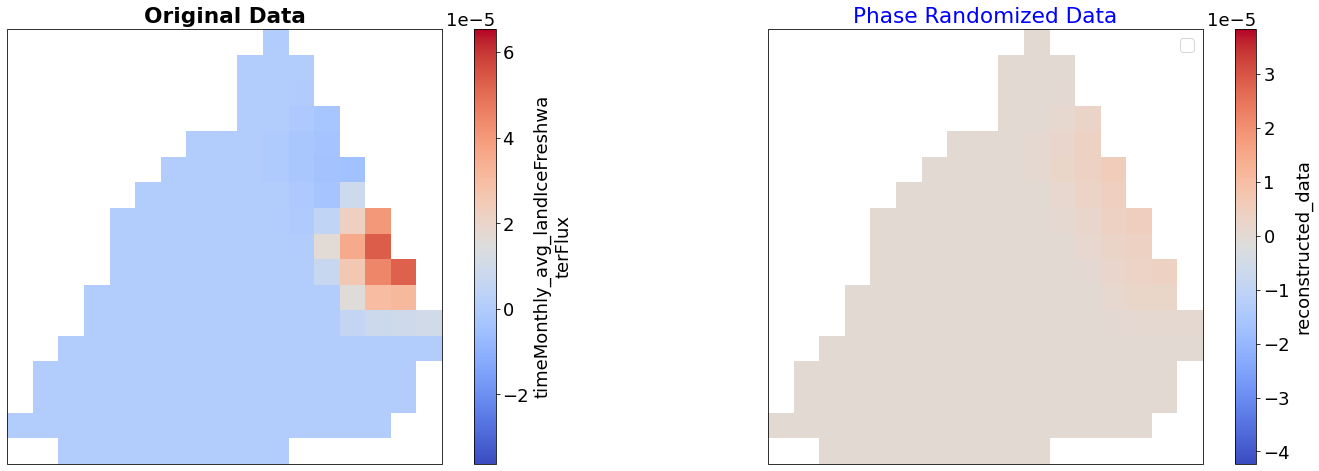

In [125]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, axs = plt.subplots(1,2,figsize=(25,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

#axs[0, 0].set_title('Axis [0, 0]')

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values
plt.subplot(121)
cax1 = orig_thw[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = np.max(orig_thw)/2, vmin = np.min(orig_thw)/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Original Data: " + str(orig_ameryn.coords['time'].values[frame])[:7])
plt.title("Original Data", color= 'black', fontweight='bold')


plt.subplot(122)
cax2 = rec_thw[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = np.max(rec_thw)/2, vmin = np.min(rec_thw)/2,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("Phase Randomized Data", color= 'blue')

#plt.subplot(2,2,(3,4))
#cax3, = plt.plot(orig_ts, 'k', linewidth=2, label = 'Original Data')
#cax4, = plt.plot(rec_ts,  'b', linewidth=1, label = 'Phase Randomized Data')

plt.legend()

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax1.set_array(orig_thw[frame,:,:].values.flatten())
    #ax.set_title('Original Simulation')
    cax2.set_array(rec_thw[frame,:,:].values.flatten())
    #ax.set_title("time = " + str(rec_ameryn.coords['time'].values[frame])[:7])
    #fig.set_title('Phase Randomized Emulation')
    #cax3.set_array(orig_ameryn_ts[frame-2:frame+2].values.flatten())
    #cax3.set_array(orig_ameryn[frame].values.flatten())
    #cax3.set_ydata(orig_ts[:frame]) # ANIMATED
    #cax3.set_xdata(range(frame)) # ANIMATED
    #cax3.set_marker('.')
    #cax3.set_markersize(0.25)
    #cax4.set_ydata(rec_ts[:frame])
    #cax4.set_xdata(range(frame))
    #cax4.set_marker('.')
    #cax4.set_markersize(0.25)

# Finally, we use the animation module to create the animation.
ani2 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(orig_thw_ts[:100]),  # Could also be iterable or list
    interval=100     # ms between frames
)

In [126]:
HTML(ani2.to_jshtml())
#ani2.save(inDirName+figures_folderpath+'WAIS_comparison_test.mp4')

In [110]:
from matplotlib import animation, rc
from IPython.display import HTML, display

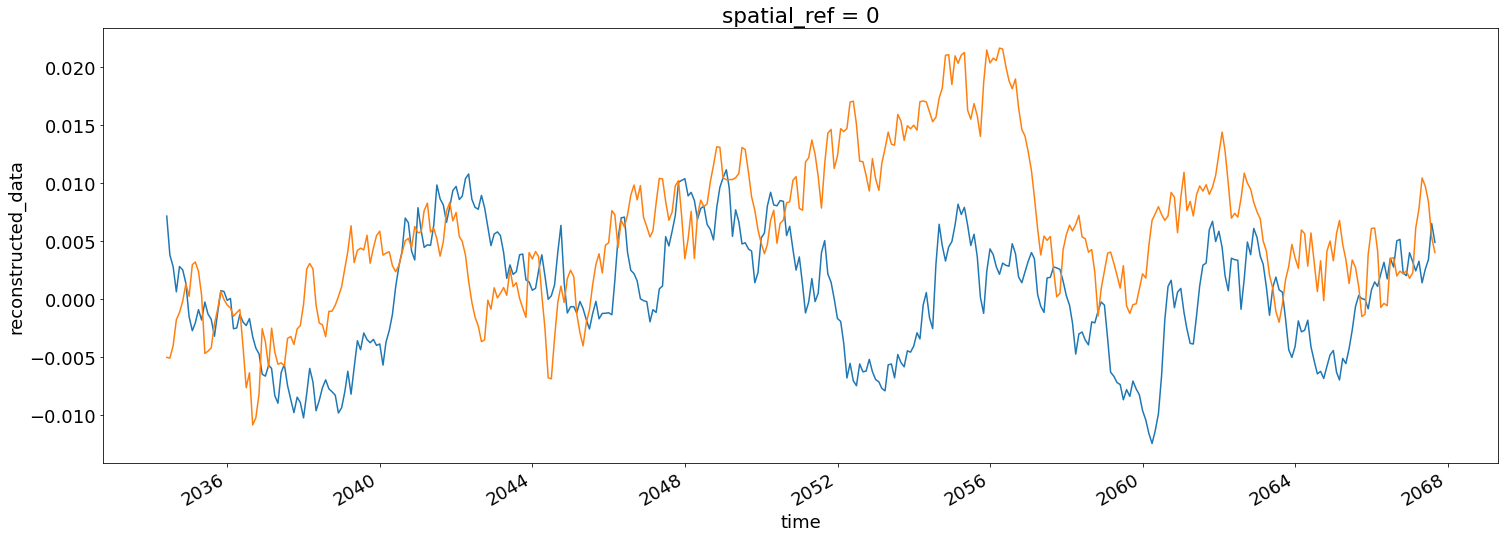

In [115]:
ti = 100
tf = 500

plt.figure(figsize=(25,8))
orig_ts[ti:tf].plot()
rec_ts[ti:tf].plot()

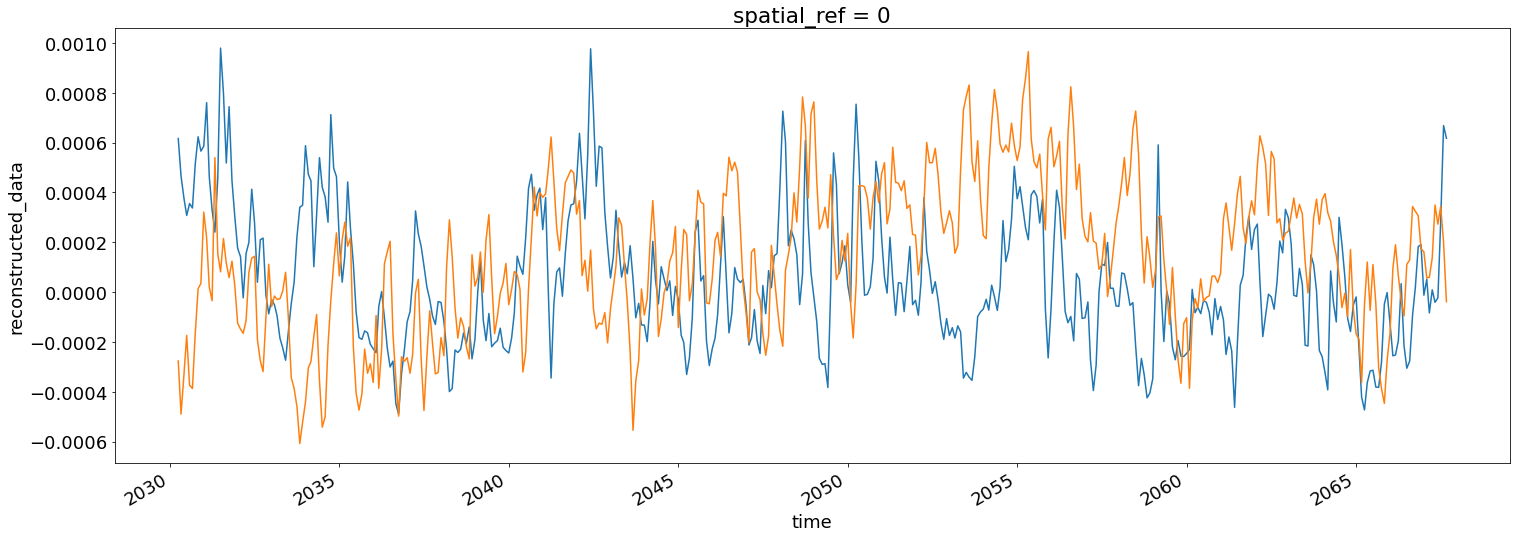

In [129]:
ti = 50
tf = 500

plt.figure(figsize=(25,8))
orig_thw_ts[ti:tf].plot()
rec_thw_ts[ti:tf].plot()